In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier


from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
def generate_colors(num):
    colors = []
    lst = list('ABCDEF0123456789')

    for i in range(num):
        colors.append('#'+''.join(np.random.choice(lst, 6)))
        
    return colors

# ----------------------------------------------------------------------
def missing_percentage(dataframe):
    """
    This function return take data frame and return data frame 
    with columns name, the number of missing values and the percentage 
    of them in each column.
    """
    total_missing = dataframe.isnull().sum().sort_values(ascending=False)
    missing_values = total_missing[total_missing.values !=0]
    missing_cols = missing_values.index
    
    missing_cols = dataframe[missing_cols].dtypes.values

    per = round((missing_values/len(dataframe))*100, 2)
    missing_df = pd.DataFrame(missing_values, columns=['Number of missing values'])
    
    return missing_df.assign(Percentage=per, Dtype=missing_cols)
#-----------------------------------------------------------------------------
def show_distribution(dataframe, col):
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    colors = generate_colors(1)
    
    sns.boxplot(data=dataframe, x=col, ax=ax[0], palette=colors)
    ax[0].set_title(f'{col.title()} Boxplot')
    
    sns.histplot(data=dataframe, x=col, ax=ax[1], color=colors, kde=True)
    ax[1].set_title(f'{col.title()} Histogram')
    
    fig.suptitle(f'{col.title()} Distribution'.replace('_', ' '), fontsize=15, color='brown')
#-----------------------------------------------------------------------------------
def show_outliers_accordingTo_target(data_frame, numeric_cols, target_col):
    plt.figure(figsize=(20, 20))
    for i in range(len(numeric_cols)):
        plt.subplot(8,4, i+1)
        sns.scatterplot(data=data_frame, x=numeric_cols[i], y=target_col, color=generate_colors(1))
        plt.title(f'{numeric_cols[i].title()} According to the Target')
        plt.subplots_adjust(hspace = 0.7, wspace=0.5)


In [3]:
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
missing_percentage(data)

Empty DataFrame
Columns: [Number of missing values, Percentage, Dtype]
Index: []

- Our data is numeric
- We have no missing values

In [6]:
data.columns = data.columns.str.lower()
data.columns

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class'],
      dtype='object')

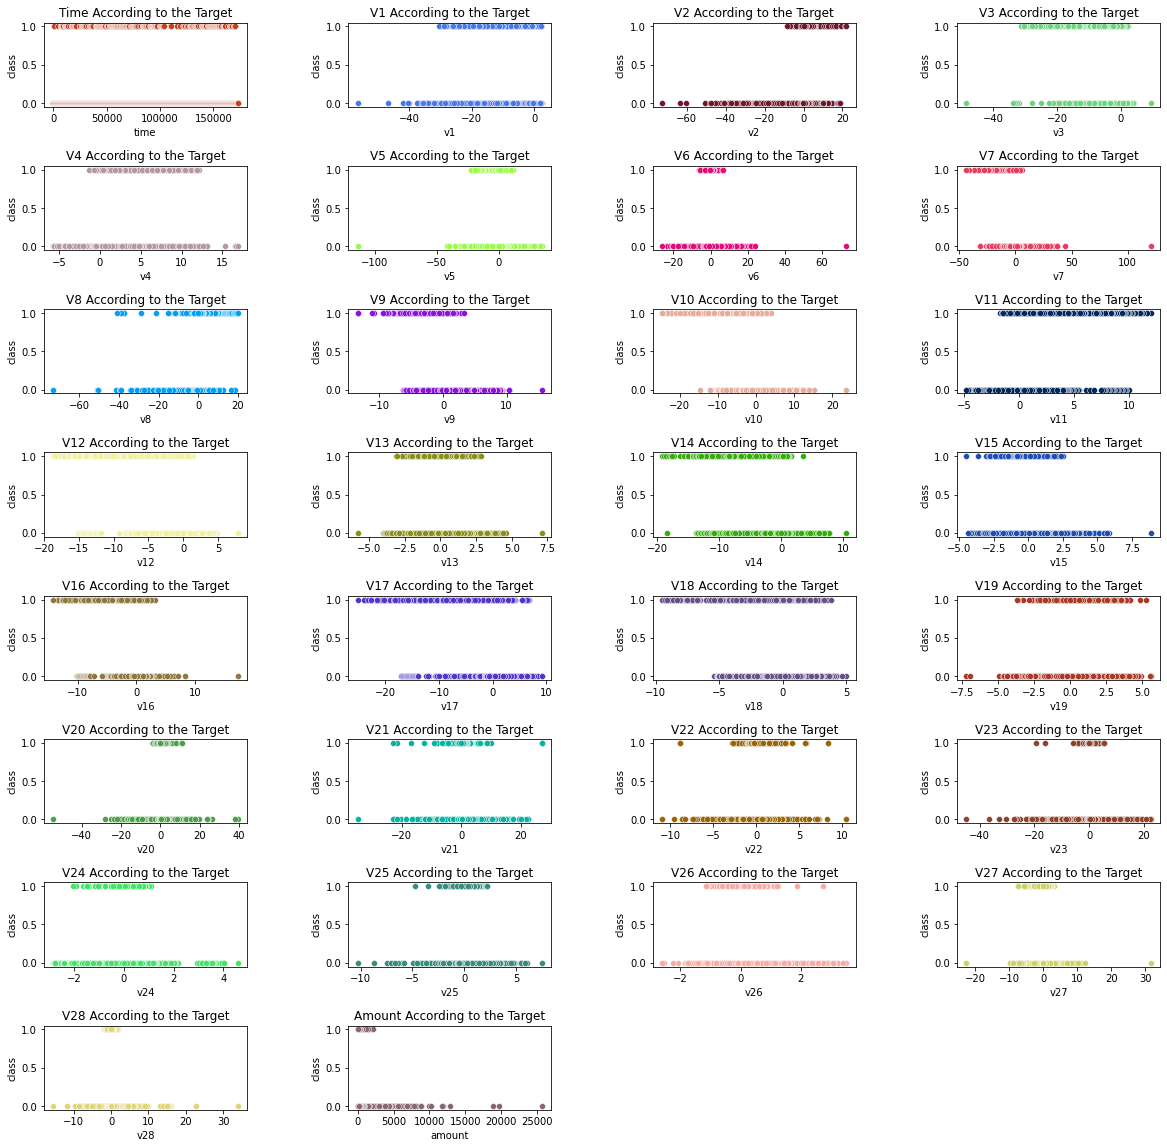

In [7]:
show_outliers_accordingTo_target(data, data.columns[:-1], 'class')

Text(0.5, 1.0, 'Target Column')

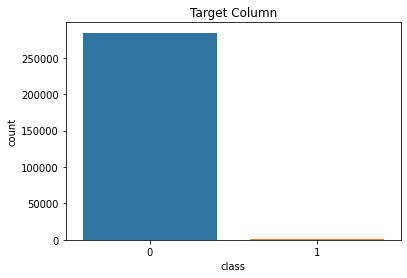

In [8]:
sns.countplot(data=data, x='class')
plt.title('Target Column')

- The problem is the data is unbalanced.
- We can observe that the outliers according to the target column in the above plots, is a little.

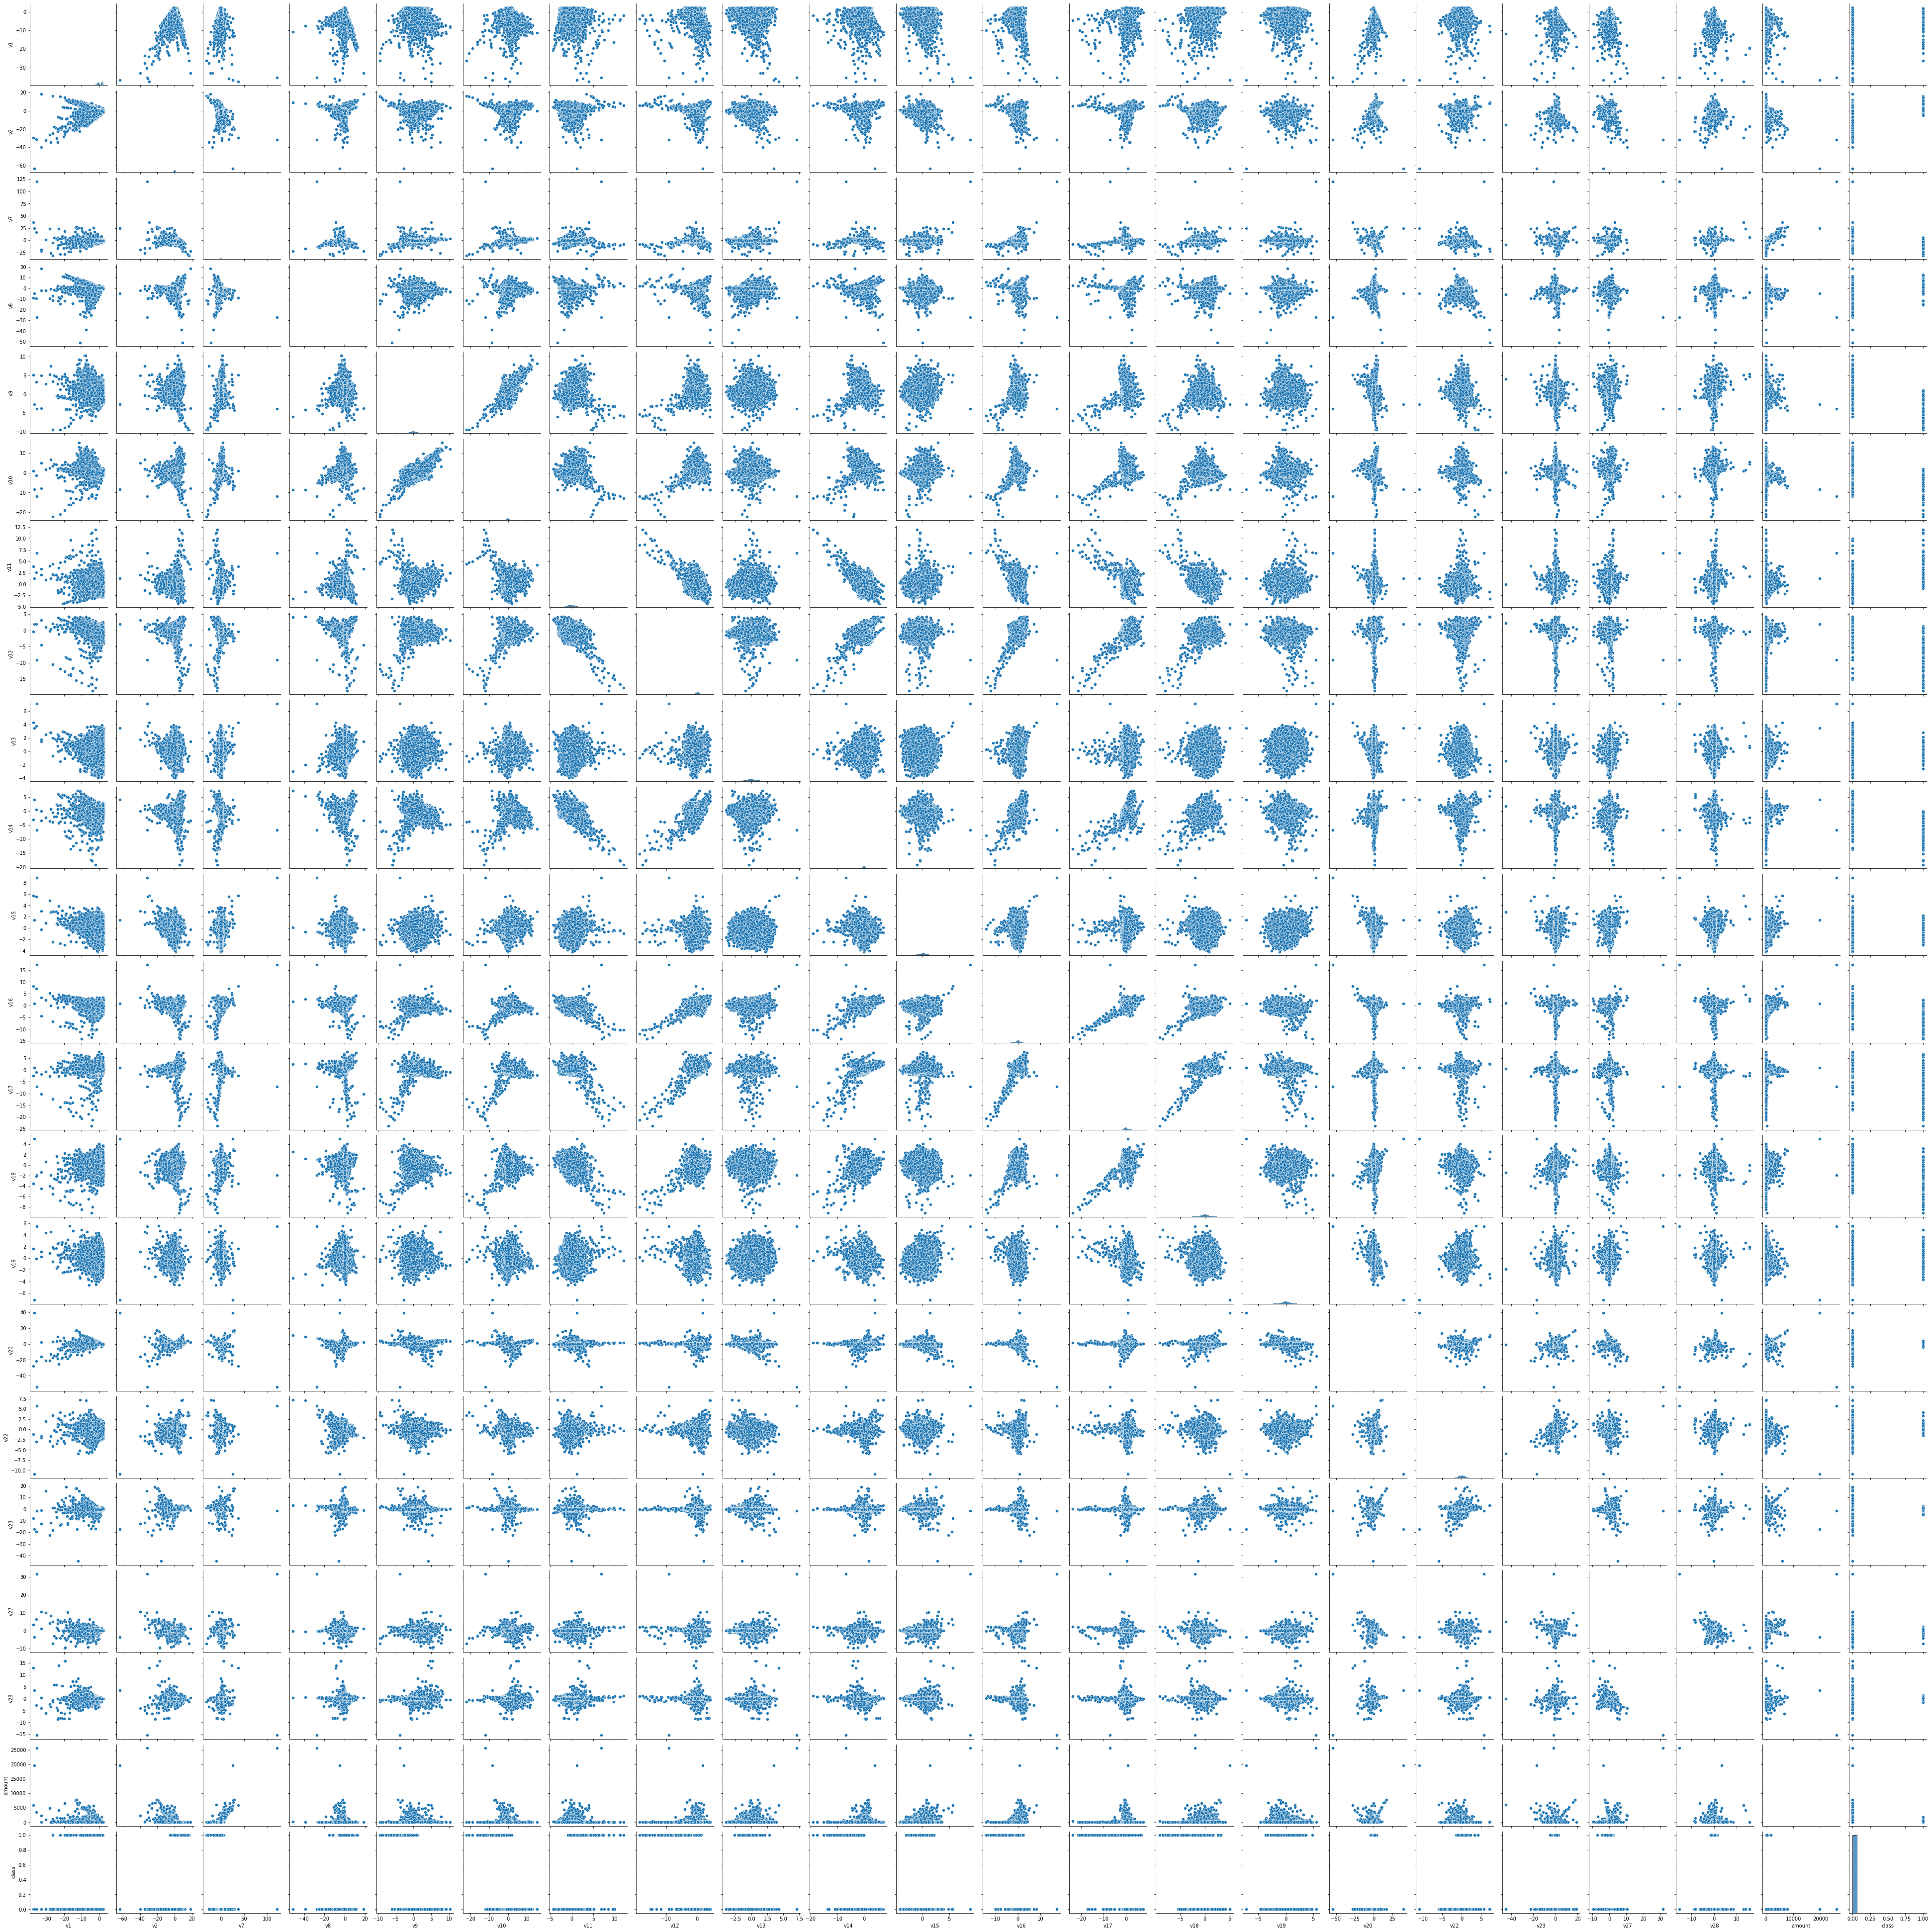

In [14]:
sns.pairplot(data.sample(frac=0.2), vars=['v1', 'v2', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
        'v22', 'v23', 'v27', 'v28', 'amount',
       'class'])

In [21]:
# Let's split our data into 2 samples. One for training and trying techniques on it. Another for final test
train, test = train_test_split(data, test_size=0.3, random_state=42)
print(train.shape)
print(test.shape)

(199364, 31)
(85443, 31)


In [10]:
# Let's try PCA on our train data to find the best feature
!pip install pca

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=21a0a11a35cd668a95e424e2ba2db087e3ca3c61a50a0680c251630373045ed6
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [30] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [27] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [30] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[27]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


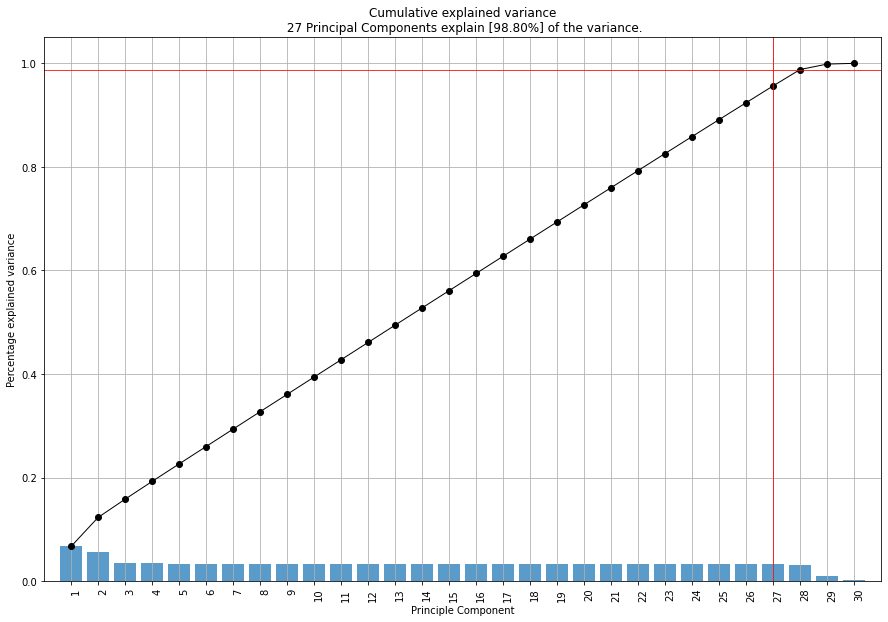

(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 27 Principal Components explain [98.80%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [11]:
from pca import pca
x = train.drop('class', axis=1)

# Reduce the data up to the number of components that explains 95% of the variance.
model = pca(normalize=True)
out = model.fit_transform(x)

model.plot()

In [12]:
out.keys()

dict_keys(['loadings', 'PC', 'explained_var', 'variance_ratio', 'model', 'scaler', 'pcp', 'topfeat', 'outliers', 'outliers_params'])

In [13]:
# Best 27 features according to pca
pca_df = pd.DataFrame(out['topfeat'])
before_scale = pca_df[pca_df['type']=='best'].feature.values
before_scale

array(['amount', 'time', 'v20', 'v2', 'v14', 'v8', 'v17', 'v16', 'v12',
       'v15', 'v10', 'v22', 'v26', 'v19', 'v25', 'v24', 'v1', 'v18',
       'v12', 'v9', 'v15', 'v14', 'v6', 'v7', 'v27', 'v21', 'v28'],
      dtype=object)

In [14]:
col_name = train.columns
col_name

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class'],
      dtype='object')

In [22]:
# Let's now try scalling and apply pca once time to see if it will change or not
# I will use robust scaler because of outliers
x = train.drop('class', axis=1)
y = train['class']

rs = RobustScaler()
x = rs.fit_transform(x)

In [23]:
x= pd.DataFrame(x, columns=col_name[:-1])
x.head()

time        v1        v2        v3        v4        v5        v6  \
0 -0.969678 -1.030212 -0.389853  0.332098 -1.059088  0.676233 -1.192189   
1  0.812155 -0.146416 -2.945667 -1.870968  0.456125  0.121703  1.551715   
2  0.149020 -0.815597 -0.452021  1.087763 -0.590082 -0.889849  1.540228   
3 -0.187784  0.527234  0.079963 -0.021674  0.302504  0.004999  0.139439   
4 -0.853951 -0.437042  0.452014  0.477666 -0.959267  0.559132  0.677572   

         v7        v8        v9       v10       v11       v12       v13  \
0  0.803458 -1.054964  1.108400 -0.344416  0.240937  0.431185  0.096363   
1  1.345127 -0.110356  0.053682 -0.268704  0.624183  0.535634 -0.206222   
2 -1.301467  1.648323  1.623019 -0.637600 -1.388244 -3.085480  0.940007   
3 -0.184212  0.249752 -0.013599 -0.036766  0.954699  0.259087 -0.563595   
4  0.259346  0.465163  1.155777 -0.572499  0.749515 -2.605257  0.923689   

        v14       v15       v16       v17       v18       v19       v20  \
0 -0.289472  0.990815 -0.972404 -0.262652 -0.609942 -0.444264 -2.227102   
1  1.112313  0.407118 -0.581118  0.156623 -0.901025 -0.972069  6.383356   
2  0.094199 -2.036713 -1.376617  1.167993  2.066073 -0.512314 -1.422437   
3  0.056108  0.587422  0.458312  0.025136 -0.027958 -0.154792 -0.252931   
4  1.654507 -0.435024  0.831250 -0.364569  0.482645 -0.519790  0.535705   

        v21       v22       v23       v24       v25       v26       v27  \
0 -0.435973  0.850818  2.842233  0.481457  0.442754 -1.284649  2.407552   
1  2.127259 -0.090724 -2.994499 -1.100847 -0.768663  1.233309 -1.795297   
2 -1.156453 -0.402212 -0.834661 -0.038627  0.676678  1.557322 -0.391749   
3 -0.507345 -0.696721  0.412271 -0.522316  0.165667  0.317538 -0.112026   
4 -0.601428 -0.444490 -0.366895 -1.800962 -0.377574  1.469108  2.145658   

        v28     amount  
0 -1.209034  -0.292622  
1  0.751940  16.334982  
2  0.582663   0.738522  
3  0.004198  -0.278966  
4  1.556082   0.213335

In [27]:
train = train.reset_index(drop=True)
train.head()

time        v1        v2        v3        v4        v5        v6  \
0    2105.0 -2.289565 -0.480260  0.818685 -1.706423  0.822102 -1.660326   
1  153702.0 -0.313717 -4.064342 -3.398445  0.704011  0.101662  1.529848   
2   97283.0 -1.809763 -0.567439  2.265186 -0.960318 -1.212537  1.516493   
3   68628.0  1.192319  0.178575  0.141491  0.459628 -0.049959 -0.112122   
4   11951.0 -0.963451  0.700311  1.097333 -1.547626  0.669966  0.513533   

         v7        v8        v9       v10       v11       v12       v13  \
0  0.944047 -0.541765  1.323156 -0.434426  0.330147  0.582071  0.112201   
1  1.551670 -0.036774  0.015829 -0.359561  0.905251  0.689143 -0.283648   
2 -1.417176  0.903421  1.961027 -0.724328 -2.114621 -3.022907  1.215878   
3 -0.163883  0.155740 -0.067566 -0.130220  1.401227  0.405652 -0.751172   
4  0.333683  0.270900  1.381880 -0.659956  1.093326 -2.530624  1.194529   

        v14       v15       v16       v17       v18       v19       v20  \
0 -0.215089  1.267783 -0.896319 -0.298897 -0.613436 -0.401911 -0.831985   
1  1.074658  0.549725 -0.508424  0.072520 -0.904567 -0.884600  2.142593   
2  0.137917 -2.456654 -1.297028  0.968448  2.063020 -0.464144 -0.554004   
3  0.102870  0.771533  0.521996 -0.043959 -0.031356 -0.137183 -0.149985   
4  1.573518 -0.486271  0.891702 -0.389181  0.479331 -0.470981  0.122458   

        v21       v22       v23       v24       v25       v26       v27  \
0 -0.210837  0.914737  0.867888  0.422969  0.310584 -0.781488  0.392241   
1  0.853186 -0.091941 -0.936215 -0.833081 -0.498728  0.651183 -0.290331   
2 -0.509915 -0.424978 -0.268621  0.010121  0.466862  0.835540 -0.062385   
3 -0.240464 -0.739862  0.116799 -0.373837  0.125470  0.130126 -0.016956   
4 -0.279519 -0.470181 -0.124037 -1.388839 -0.237453  0.785347  0.349708   

        v28   amount  class  
0 -0.147757     1.00      0  
1  0.110360  1194.28      0  
2  0.088079    75.00      0  
3  0.011937     1.98      0  
4  0.216207    37.31      0

In [28]:
train.update(x)

In [30]:
train.head()

time        v1        v2        v3        v4        v5        v6  \
0 -0.969678 -1.030212 -0.389853  0.332098 -1.059088  0.676233 -1.192189   
1  0.812155 -0.146416 -2.945667 -1.870968  0.456125  0.121703  1.551715   
2  0.149020 -0.815597 -0.452021  1.087763 -0.590082 -0.889849  1.540228   
3 -0.187784  0.527234  0.079963 -0.021674  0.302504  0.004999  0.139439   
4 -0.853951 -0.437042  0.452014  0.477666 -0.959267  0.559132  0.677572   

         v7        v8        v9       v10       v11       v12       v13  \
0  0.803458 -1.054964  1.108400 -0.344416  0.240937  0.431185  0.096363   
1  1.345127 -0.110356  0.053682 -0.268704  0.624183  0.535634 -0.206222   
2 -1.301467  1.648323  1.623019 -0.637600 -1.388244 -3.085480  0.940007   
3 -0.184212  0.249752 -0.013599 -0.036766  0.954699  0.259087 -0.563595   
4  0.259346  0.465163  1.155777 -0.572499  0.749515 -2.605257  0.923689   

        v14       v15       v16       v17       v18       v19       v20  \
0 -0.289472  0.990815 -0.972404 -0.262652 -0.609942 -0.444264 -2.227102   
1  1.112313  0.407118 -0.581118  0.156623 -0.901025 -0.972069  6.383356   
2  0.094199 -2.036713 -1.376617  1.167993  2.066073 -0.512314 -1.422437   
3  0.056108  0.587422  0.458312  0.025136 -0.027958 -0.154792 -0.252931   
4  1.654507 -0.435024  0.831250 -0.364569  0.482645 -0.519790  0.535705   

        v21       v22       v23       v24       v25       v26       v27  \
0 -0.435973  0.850818  2.842233  0.481457  0.442754 -1.284649  2.407552   
1  2.127259 -0.090724 -2.994499 -1.100847 -0.768663  1.233309 -1.795297   
2 -1.156453 -0.402212 -0.834661 -0.038627  0.676678  1.557322 -0.391749   
3 -0.507345 -0.696721  0.412271 -0.522316  0.165667  0.317538 -0.112026   
4 -0.601428 -0.444490 -0.366895 -1.800962 -0.377574  1.469108  2.145658   

        v28     amount  class  
0 -1.209034  -0.292622      0  
1  0.751940  16.334982      0  
2  0.582663   0.738522      0  
3  0.004198  -0.278966      0  
4  1.556082   0.213335      0

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [30] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [27] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [30] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[27]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


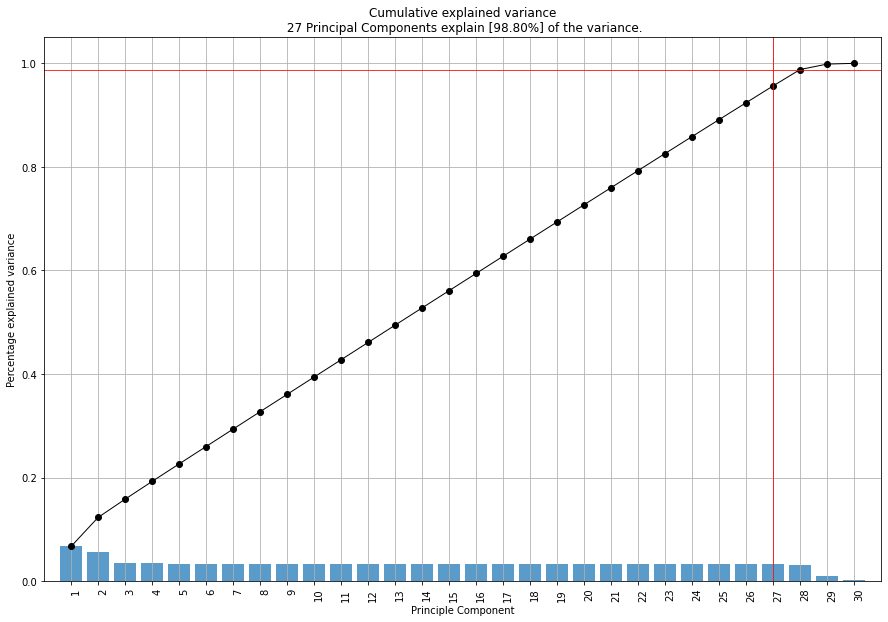

(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 27 Principal Components explain [98.80%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [31]:
x = train.drop('class', axis=1)

# Reduce the data up to the number of components that explains 95% of the variance.
model = pca(normalize=True)
out = model.fit_transform(x)

model.plot()

In [32]:
# Best 27 features according to pca
pca_df = pd.DataFrame(out['topfeat'])
after_scale = pca_df[pca_df['type']=='best'].feature.values
after_scale

array(['amount', 'time', 'v20', 'v2', 'v14', 'v8', 'v17', 'v16', 'v12',
       'v15', 'v10', 'v22', 'v26', 'v19', 'v25', 'v24', 'v1', 'v18',
       'v12', 'v9', 'v15', 'v14', 'v6', 'v7', 'v27', 'v21', 'v28'],
      dtype=object)

In [33]:
set(after_scale)-set(before_scale)

set()

In [88]:
len(after_scale), len(set(after_scale))

(27, 24)

> We can see that the best features according to PCA didn't change while scaling data.

In [89]:
final_train = pd.concat([train[set(after_scale)], train['class']], axis=1)
final_train

v18        v6       v22       v15       v26        v7        v8  \
0      -0.609942 -1.192189  0.850818  0.990815 -1.284649  0.803458 -1.054964   
1      -0.901025  1.551715 -0.090724  0.407118  1.233309  1.345127 -0.110356   
2       2.066073  1.540228 -0.402212 -2.036713  1.557322 -1.301467  1.648323   
3      -0.027958  0.139439 -0.696721  0.587422  0.317538 -0.184212  0.249752   
4       0.482645  0.677572 -0.444490 -0.435024  1.469108  0.259346  0.465163   
...          ...       ...       ...       ...       ...       ...       ...   
199359 -0.407462  0.052530 -0.541856  0.495852  0.280820 -0.185435  0.181441   
199360 -0.059793  3.600696 -0.023040  0.598940 -1.266112 -0.453631  2.503535   
199361 -0.064970 -0.465285  0.326446  0.521308 -0.611480  0.921659 -0.781025   
199362 -0.943287  2.581997 -0.984467 -0.112955  0.838088 -0.458679  4.106438   
199363 -1.310411 -0.312039 -0.224079  0.686702 -0.602002 -0.485957 -0.393338   

             v16       v17       v10        v1       v14       v28       v12  \
0      -0.972404 -0.262652 -0.344416 -1.030212 -0.289472 -1.209034  0.431185   
1      -0.581118  0.156623 -0.268704 -0.146416  1.112313  0.751940  0.535634   
2      -1.376617  1.167993 -0.637600 -0.815597  0.094199  0.582663 -3.085480   
3       0.458312  0.025136 -0.036766  0.527234  0.056108  0.004198  0.259087   
4       0.831250 -0.364569 -0.572499 -0.437042  1.654507  1.556082 -2.605257   
...          ...       ...       ...       ...       ...       ...       ...   
199359  0.173413 -0.327996  0.174951  0.518810  0.597440 -0.056350  0.621347   
199360 -0.009742 -0.447366 -0.566505 -0.353186  0.362338  0.954753  0.201324   
199361 -0.214292 -0.534694 -0.120234 -0.071668 -0.076885 -1.577035 -0.114381   
199362  0.361590 -0.372433  0.067044 -1.325015  0.952682  2.464826  0.419800   
199363  1.392243  0.028966  0.644091  0.545508 -0.431982  0.206670 -0.534172   

              v2       v25        v9      time       v27       v24     amount  \
0      -0.389853  0.442754  1.108400 -0.969678  2.407552  0.481457  -0.292622   
1      -2.945667 -0.768663  0.053682  0.812155 -1.795297 -1.100847  16.334982   
2      -0.452021  0.676678  1.623019  0.149020 -0.391749 -0.038627   0.738522   
3       0.079963  0.165667 -0.013599 -0.187784 -0.112026 -0.522316  -0.278966   
4       0.452014 -0.377574  1.155777 -0.853951  2.145658 -1.800962   0.213335   
...          ...       ...       ...       ...       ...       ...        ...   
199359  0.024496  0.114735 -0.051221 -0.105625 -0.136448 -0.059111  -0.278966   
199360  0.055324 -2.469653  0.364183  0.874426  0.398803  0.808804   0.936808   
199361  0.660692  0.333184 -0.355459 -0.056530 -0.753519  0.456112  -0.251655   
199362  1.631868  0.456414  0.509002  0.039099  3.052048  0.803827  -0.292622   
199363 -0.607057  0.412430 -0.563877 -0.096657 -0.000130 -0.188781   1.268028   

             v21       v20       v19  class  
0      -0.435973 -2.227102 -0.444264      0  
1       2.127259  6.383356 -0.972069      0  
2      -1.156453 -1.422437 -0.512314      0  
3      -0.507345 -0.252931 -0.154792      0  
4      -0.601428  0.535705 -0.519790      0  
...          ...       ...       ...    ...  
199359 -0.376205 -0.274781 -0.204337      0  
199360  0.161254 -0.674814  0.098769      0  
199361  0.198765  0.201941 -0.255862      0  
199362 -0.729683  1.389458 -1.255444      0  
199363  0.138504  1.158858  0.731740      0  

[199364 rows x 25 columns]

In [90]:
x = final_train.drop('class', axis=1)
y = final_train['class']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, random_state=42, test_size=0.25)
x_train.shape, x_valid.shape

((149523, 24), (49841, 24))

<AxesSubplot:xlabel='class', ylabel='count'>

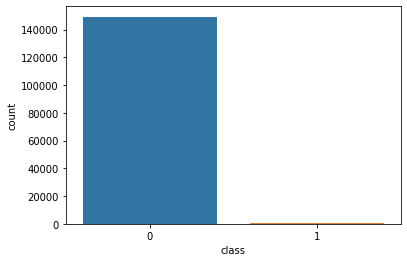

In [91]:
sns.countplot(y_train)

- As we can see that the data is imbalance, I will use SMOTE. After that I will try ML algorithms

In [92]:
sm = SMOTE(random_state=42)
x_train_res , y_train_res = sm.fit_resample(x_train.values, y_train.ravel())

(298512, 24)


<AxesSubplot:ylabel='count'>

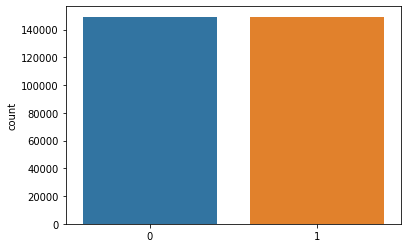

In [93]:
print(x_train_res.shape)

sns.countplot(y_train_res)

In [94]:
np.random.seed(42)
num = sorted(np.random.randint(1,20,3))
num

[7, 11, 15]

In [95]:
print('Logistic Regression')
for i in num:
    log_model = LogisticRegression(C=i, solver='saga')
    log_model.fit(x_train_res, y_train_res)
    y_pred = log_model.predict(x_valid)
    
    print(f'Training Score : {log_model.score(x_train_res, y_train_res)}')
    print(f'Validation Score : {log_model.score(x_valid, y_valid)}')
    
    print(classification_report(y_valid, y_pred), end='\n\n')

Logistic Regression
Training Score : 0.9430039663397116
Validation Score : 0.9759635641339459
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49752
           1       0.06      0.84      0.11        89

    accuracy                           0.98     49841
   macro avg       0.53      0.91      0.55     49841
weighted avg       1.00      0.98      0.99     49841


Training Score : 0.9430039663397116
Validation Score : 0.9759635641339459
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49752
           1       0.06      0.84      0.11        89

    accuracy                           0.98     49841
   macro avg       0.53      0.91      0.55     49841
weighted avg       1.00      0.98      0.99     49841


Training Score : 0.9430039663397116
Validation Score : 0.9759635641339459
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    

In [96]:
print('Random Forest : ')

for i in [50, 120, 200]:
    model = RandomForestClassifier(n_estimators=i)
    model.fit(x_train_res, y_train_res)
    y_pred = model.predict(x_valid)
    
    print(f'Training Score : {model.score(x_train_res, y_train_res)}')
    print(f'Validation Score : {model.score(x_valid, y_valid)}')
    
    print(classification_report(y_valid, y_pred), end='\n\n')

Random Forest : 
Training Score : 1.0
Validation Score : 0.999297766898738
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49752
           1       0.80      0.81      0.80        89

    accuracy                           1.00     49841
   macro avg       0.90      0.90      0.90     49841
weighted avg       1.00      1.00      1.00     49841


Training Score : 1.0
Validation Score : 0.999297766898738
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49752
           1       0.81      0.79      0.80        89

    accuracy                           1.00     49841
   macro avg       0.91      0.89      0.90     49841
weighted avg       1.00      1.00      1.00     49841


Training Score : 1.0
Validation Score : 0.9992777030958447
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49752
           1       0.80      0.79      0.80

In [59]:
# print('Random Forest : ')
# para_grid=[
#     {'n_estimators':[50,120,200],'max_features':[9,15,20]}
# ]

# randomForest_model = GridSearchCV(estimator=RandomForestClassifier(), param_grid=para_grid, cv=5, scoring='f1')
# randomForest_model.fit(x_train_res, y_train_res)

Sorted Index : [ 2 19  3 15 17  4 22 12 20 10  6 18 23  1 21  0 16 14  7  5  8  9 13 11]


Text(0.5, 1.0, 'Feature Importance')

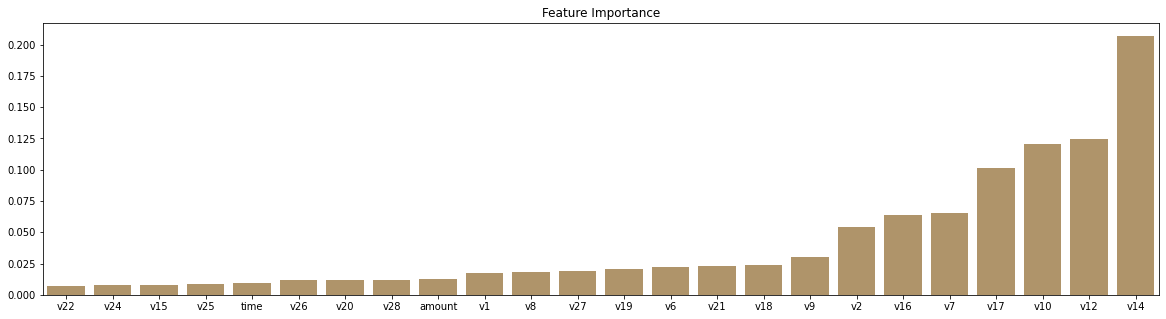

In [98]:
plt.figure(figsize=(20,5))
sorted_index = model.feature_importances_.argsort()
print(f'Sorted Index : {sorted_index}')
sns.barplot(x_train.columns[sorted_index], model.feature_importances_[sorted_index], palette=generate_colors(1))
plt.title('Feature Importance')

In [99]:
print('Decision Tree : ')

for i in [8, 15, 22]:
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(x_train_res, y_train_res)
    y_pred = model.predict(x_valid)
    
    print(f'Training Score : {model.score(x_train_res, y_train_res)}')
    print(f'Validation Score : {model.score(x_valid, y_valid)}')
    
    print(classification_report(y_valid, y_pred), end='\n\n')

Decision Tree : 
Training Score : 0.9787043736935198
Validation Score : 0.9796151762605084
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49752
           1       0.07      0.84      0.13        89

    accuracy                           0.98     49841
   macro avg       0.53      0.91      0.56     49841
weighted avg       1.00      0.98      0.99     49841


Training Score : 0.9978225330974969
Validation Score : 0.9932786260307779
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     49752
           1       0.18      0.79      0.29        89

    accuracy                           0.99     49841
   macro avg       0.59      0.89      0.65     49841
weighted avg       1.00      0.99      1.00     49841


Training Score : 0.9995042075360454
Validation Score : 0.9959872394213599
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49

In [100]:
# I will use adaboosting classifier with base_estimator random forest which gave high F1-score above.
print('AdaBoosting Classifier : ')

model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=50), n_estimators=4)
model.fit(x_train_res, y_train_res)
y_pred = model.predict(x_valid)
    
print(f'Training Score : {model.score(x_train_res, y_train_res)}')
print(f'Validation Score : {model.score(x_valid, y_valid)}')
    
print(classification_report(y_valid, y_pred), end='\n\n')

AdaBoosting Classifier : 
Training Score : 1.0
Validation Score : 0.9992777030958447
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49752
           1       0.80      0.79      0.80        89

    accuracy                           1.00     49841
   macro avg       0.90      0.89      0.90     49841
weighted avg       1.00      1.00      1.00     49841




In [101]:
print('GradientBoosting Classifier : ')

model = GradientBoostingClassifier(n_estimators=7)
model.fit(x_train_res, y_train_res)
y_pred = model.predict(x_valid)
    
print(f'Training Score : {model.score(x_train_res, y_train_res)}')
print(f'Validation Score : {model.score(x_valid, y_valid)}')
    
print(classification_report(y_valid, y_pred), end='\n\n')

GradientBoosting Classifier : 
Training Score : 0.9433222115023852
Validation Score : 0.9785317309042756
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49752
           1       0.07      0.84      0.12        89

    accuracy                           0.98     49841
   macro avg       0.53      0.91      0.56     49841
weighted avg       1.00      0.98      0.99     49841




In [102]:
print('XGB Classifier : ')

model = xgb.XGBClassifier(n_estimators=11)
model.fit(x_train_res, y_train_res)
y_pred = model.predict(x_valid)
    
print(f'Training Score : {model.score(x_train_res, y_train_res)}')
print(f'Validation Score : {model.score(x_valid, y_valid)}')
    
print(classification_report(y_valid, y_pred), end='\n\n')

XGB Classifier : 
Training Score : 0.9865231548480463
Validation Score : 0.9911518629240986
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     49752
           1       0.15      0.82      0.25        89

    accuracy                           0.99     49841
   macro avg       0.57      0.91      0.62     49841
weighted avg       1.00      0.99      0.99     49841




In [104]:
print('CatBoost Classifier : ')

model = CatBoostClassifier(iterations=50)
model.fit(x_train_res, y_train_res)
y_pred = model.predict(x_valid)

CatBoost Classifier : 
Learning rate set to 0.5
0:	learn: 0.1797429	total: 61.5ms	remaining: 3.01s
1:	learn: 0.1345547	total: 119ms	remaining: 2.85s
2:	learn: 0.1059853	total: 173ms	remaining: 2.7s
3:	learn: 0.0933095	total: 228ms	remaining: 2.62s
4:	learn: 0.0807282	total: 281ms	remaining: 2.53s
5:	learn: 0.0706622	total: 337ms	remaining: 2.47s
6:	learn: 0.0660453	total: 390ms	remaining: 2.39s
7:	learn: 0.0602878	total: 448ms	remaining: 2.35s
8:	learn: 0.0522497	total: 501ms	remaining: 2.28s
9:	learn: 0.0474475	total: 550ms	remaining: 2.2s
10:	learn: 0.0417904	total: 605ms	remaining: 2.15s
11:	learn: 0.0373008	total: 661ms	remaining: 2.09s
12:	learn: 0.0338484	total: 721ms	remaining: 2.05s
13:	learn: 0.0316260	total: 775ms	remaining: 1.99s
14:	learn: 0.0287406	total: 831ms	remaining: 1.94s
15:	learn: 0.0268572	total: 901ms	remaining: 1.92s
16:	learn: 0.0256889	total: 946ms	remaining: 1.83s
17:	learn: 0.0237875	total: 997ms	remaining: 1.77s
18:	learn: 0.0218466	total: 1.05s	remaining: 

In [105]:
print(f'Training Score : {model.score(x_train_res, y_train_res)}')
print(f'Validation Score : {model.score(x_valid, y_valid)}')
    
print(classification_report(y_valid, y_pred), end='\n\n')

Training Score : 0.9994037090636222
Validation Score : 0.9975722798499228
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49752
           1       0.41      0.81      0.54        89

    accuracy                           1.00     49841
   macro avg       0.70      0.90      0.77     49841
weighted avg       1.00      1.00      1.00     49841


